In [1]:
%matplotlib inline
import os
import mne
import pandas as pd
from mne.externals.pymatreader import read_mat
import numpy as np
import matplotlib.pyplot as plt
import itertools
from glob import glob
import pyriemann
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score
from sklearn.pipeline import make_pipeline
from sklearn.metrics import accuracy_score



In [8]:
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
# from tensorflow.keras.layers import Flatten
# from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import LSTM
from tensorflow.keras.utils import to_categorical
from tensorflow.python.keras.layers.core import Dropout
from tensorflow.keras.layers import Conv1D


In [3]:
data_path = 'C:\\Users\\frank\\code\\NeuroErgonomics_Hackathon_2021'
#'/home/dcas/l.darmet/data/contest/comeptition_done'
n_subs = 1
n_sessions = 2
diff = ['MATBeasy', 'MATBmed', 'MATBdiff']

ch_slice = ['F7', 'F5', 'F3', 'F1', 'F2', 'F4', 'F6', 'AF3', 'AFz', 'AF4','FP1', 'FP2', 'FPz']

In [4]:
params =        {'verbose':1,
                'epochs': 5, 
                'batch_size' :200,
                'loss' : 'categorical_crossentropy', 
                }    

Epoch 1/5
3/3 [==============================] - 4s 1s/step - loss: 1.0989 - accuracy: 0.3244 - val_loss: 1.0983 - val_accuracy: 0.3889
Epoch 2/5
3/3 [==============================] - 4s 1s/step - loss: 1.0985 - accuracy: 0.3333 - val_loss: 1.0982 - val_accuracy: 0.3889
Epoch 3/5
3/3 [==============================] - 4s 1s/step - loss: 1.0988 - accuracy: 0.3289 - val_loss: 1.0987 - val_accuracy: 0.3889
Epoch 4/5
3/3 [==============================] - 4s 1s/step - loss: 1.0988 - accuracy: 0.3221 - val_loss: 1.0991 - val_accuracy: 0.2667
Epoch 5/5
3/3 [==============================] - 4s 1s/step - loss: 1.0995 - accuracy: 0.2975 - val_loss: 1.1002 - val_accuracy: 0.2667
Epoch 1/5
3/3 [==============================] - 4s 1s/step - loss: 1.0989 - accuracy: 0.3177 - val_loss: 1.0984 - val_accuracy: 0.3444
Epoch 2/5
3/3 [==============================] - 4s 1s/step - loss: 1.0988 - accuracy: 0.3333 - val_loss: 1.0986 - val_accuracy: 0.3444
Epoch 3/5
3/3 [==============================] -

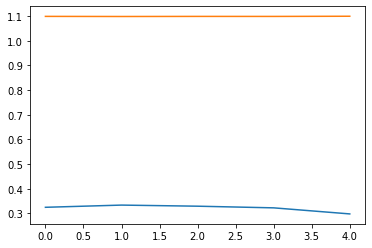

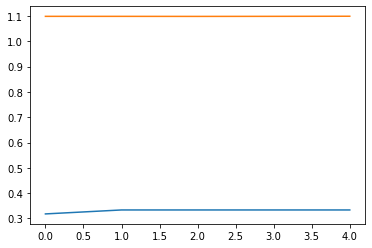

In [21]:
for sub_n, session_n in itertools.product(range(n_subs), range(n_sessions)):
    epochs_data = []
    labels = []
    for lab_idx, level in enumerate(diff):
        sub = 'P{0:02d}'.format(sub_n+1)
        sess = f'S{session_n+1}'
        path = os.path.join(os.path.join(data_path, sub), sess) + f'/eeg/alldata_sbj{str(sub_n+1).zfill(2)}_sess{session_n+1}_{level}.set'
        # Read the epoched data with MNE
        epochs = mne.io.read_epochs_eeglab(path, verbose=False)
        # You could add some pre-processing here with MNE
        # We will just select some channels (mostly frontal ones)
        epochs = epochs.drop_channels(list(set(epochs.ch_names) -set(ch_slice)))

        # Get the data and concatenante with others MATB levels
        tmp = epochs.get_data()
        epochs_data.extend(tmp)
        labels.extend([lab_idx]*len(tmp))
    
    
    epochs_data = np.transpose(epochs_data, (0,2,1))
    X = np.array(epochs_data)
    
#     scale = StandardScaler()
#     scale.fit(epochs_data)
#     epochs_data = scale.transform(epochs_data)
    
    labels = np.array(labels)
    
    labels_cat = to_categorical(labels)
    y = labels_cat
#     print(labels)
#     print(y)
#     print(X.shape)
    
    X_train, X_val, y_train, y_val = train_test_split(
            X, y, test_size=0.2, random_state=42)
    
    n_timesteps, n_features, n_outputs = X_train.shape[1], X_train.shape[2], y_train.shape[1]
    
    model = Sequential()
    model.add(LSTM(300, input_shape=(n_timesteps,n_features)))
#     model.add(Conv1D(300, kernel_size=10, activation='relu', input_shape=(n_timesteps,n_features)))
#     model.add(Conv1D(300, kernel_size=10, activation='relu', input_shape=(n_timesteps,n_features)))
    model.add(Dropout(0.2))
    model.add(Dense(100, activation='relu'))
    model.add(Dropout(0.2))
    model.add(Dense(20, activation='relu'))
    
    model.add(Dense(n_outputs, activation='softmax'))
    model.compile(loss=params['loss'], optimizer='adam', metrics=['accuracy'])      

    
    history = model.fit(epochs_data, labels_cat, epochs=params['epochs'], batch_size=params['batch_size'], \
            verbose=params['verbose'], validation_data = (X_val, y_val))
    plt.figure()
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['loss'])


In [11]:
print(X.shape)
print(X_train.shape)
print(X_val.shape)


(447, 500, 61)
(357, 500, 61)
(90, 500, 61)


In [19]:
print(y.shape)
print(y_train.shape)
print(y_val.shape)

(447, 3)
(357, 3)
(90, 3)


In [20]:
print(y.sum(axis=0))
print(y_train.sum(axis=0))
print(y_val.sum(axis=0))

[149. 149. 149.]
[114. 125. 118.]
[35. 24. 31.]
